In [1]:
import numpy as np
import os

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

## data loading/conversion, functions for fitting t0/chirp dispersion

In [2]:
raw_data = {
    1.0  : 'mmCPD_TA_dec2021_data/with_dna/mmCPD_10DNA_1mW_bgsubstracted.dat',
    4.0  : 'mmCPD_TA_dec2021_data/with_dna/mmCPD_10DNA_4mW_bgsubstracted.dat',
    24.0 : 'mmCPD_TA_dec2021_data/with_dna/mmCPD_10DNA_24mW_bgsubstracted.dat',
    8.0  : 'mmCPD_TA_dec2021_data/with_dna/mmCPD_10DNA_8mW_bgsubstracted.dat',
    2.0  : 'mmCPD_TA_dec2021_data/with_dna/mmCPD_10DNA_2mW_bgsubstracted.dat',
    9.4  : 'mmCPD_TA_dec2021_data/with_dna/mmCPD_10DNA_9point4mW_bgsubstracted.dat',
    40.0 : 'mmCPD_TA_dec2021_data/with_dna/mmCPD_10DNA_40mW_bgsubstracted.dat',
    -2.0   : 'mmCPD_TA_dec2021_data/without_dna/mmcpd_noDNA_2mW_bgsubstracted.dat'
}

d_slice = np.s_[240:320] # a shorthand for cutting the useful wavelengths out of the data

powers = raw_data.keys()
wavelengths = np.genfromtxt('../mmCPD_TA_dec2021_data/Wavelengths.txt')[1,d_slice] * 1000.0

In [49]:
def load_raw(power):
    d = np.genfromtxt( "../" + raw_data[power] )
    d = np.nan_to_num(d)
    return d[1:,0], d[1:,d_slice]


def gauss_sin(x, *params):
    a1, mu, c1, e1, d1, f1, a2 = params
    f1 = 0.0
    f = a1 * np.exp(-(( np.square(x-mu)/c1) / 2)) * \
        np.sin(e1 + d1*(x-mu) + f1*np.square(x-mu))
    f += a2 * np.heaviside(x-mu, 0.5)
    return f


def param_erf(x, *params):
    # amplitude, t0_offset, sigma_units_time
    # (1/2) * [ erf{ (x - mu) /  (sqrt{2} * sigma) } + 1 ]
    amplitude, t_zero, sigma = params
    f = amplitude * 0.5 * ( erf( (x - t_zero) / (np.sqrt(2) * sigma)) + 1 )
    return f


def robust_polyfit(x, y, degree, z_cut=2.5):

    # first fit
    poly_coefs = np.polyfit(x, y, degree)
    poly_f     = np.poly1d(poly_coefs)
    residuals  = poly_f(x) - y
    
    r_sigma  = np.std(residuals)
    outliers = ( np.abs(residuals) > z_cut * r_sigma )
    no = np.logical_not(outliers)
    
    # refit with outliers rejected
    poly_coefs = np.polyfit(x[no], y[no], degree)
    
    return poly_coefs


def fit_t0(
    times,
    wavelengths,
    ta_data,
    irf,
    p0,
    time_max_for_fit=1000,
    poly_deg=2,
    plot=False,
    return_sigmas=False,
):
    
    # !NB current implementation relies on 2nd parameter of `irf` being t0 !

    t0s = np.zeros(len(wavelengths))
    if return_sigmas:
        sigmas = np.zeros(len(wavelengths))

    for i,w in enumerate(wavelengths):
        
        try:
            p_opt, _ = curve_fit(irf, times[:time_max_for_fit], ta_data[:time_max_for_fit,i], p0=p0)
        except Exception as e:
            print(e)
            continue

        t0s[i] = p_opt[1]
        if return_sigmas:
            sigmas[i] = p_opt[2]

        if plot:
            print(p_opt)
            plt.figure()
            plt.plot(times, ta_data[:,i])
            plt.plot(times, irf(times, *p_opt))
            plt.grid()
            plt.xscale('symlog')
            #plt.xlim([-2000,2000])
            plt.xlabel('fs')
            plt.show()
    
    poly_coefs = robust_polyfit(wavelengths, t0s, poly_deg)
    
    if return_sigmas:
        return t0s, poly_coefs, sigmas
    else:
        return t0s, poly_coefs


def fit_t0_with_erf(times, wavelengths, ta_data, plot=False, return_sigmas=False):
    irf = param_erf
    p0 = (1.0, 5e3, 5e2)
    return fit_t0(times, wavelengths, ta_data, irf, p0, plot=plot, return_sigmas=return_sigmas)


def fit_t0_with_gauss_sin(times, wavelengths, ta_data, plot=False):
    irf = gauss_sin
    p0 =  (20.0, 0.0, 100000.0, 0.0, 0.01, 0.0, 1.0)
    return fit_t0(times, wavelengths, ta_data, irf, p0, plot=plot)


def fit_t0_with_extremum(times, wavelengths, ta_data, plot=False, cutoff=1.0):
    irf = lambda d : np.where(d < - cutoff)[0]
    p0 = []
    return fit_t0(times, wavelengths, ta_data, irf, p0, plot=plot)


def dechirp(original_times, new_t0s, ta_data):
    
    data_dechirped = np.zeros_like(ta_data)
    
    for i in range(ta_data.shape[1]):
        chirped_time = original_times - new_t0s[i]
        f = interp1d(
            chirped_time,
            ta_data[:,i], 
            kind="linear",
            bounds_error=False,
            fill_value="extrapolate"
        )
                      # fill_value=(0,0))
        data_dechirped[:,i] = f(original_times)
        
    return data_dechirped


def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

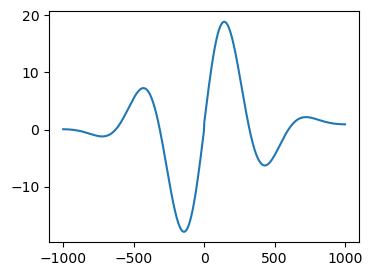

In [50]:
# inspect the physical fit from Anke
# amp, t0, sigma, phase_offset, freq, chirp, final_amp

p0 = (20.0, 0.0, 100000.0, 0.0, 0.01, 0.0, 1.0)
x = np.linspace(-1e3, 1e3, 1000)
y = gauss_sin(x, *p0)

plt.figure(figsize=(4,3))
plt.plot(x, y)
plt.show()

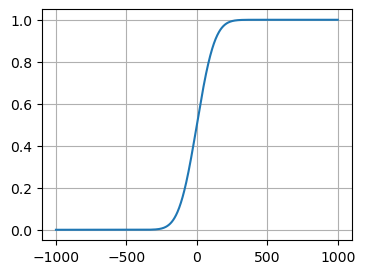

In [51]:
# inverse_time, time_offset, amplitude

p0 = (1.0, 0.0, 1e2)
x = np.linspace(-1e3, 1e3, 1000)
y = param_erf(x, *p0)

plt.figure(figsize=(4,3))
plt.plot(x, y)
plt.grid()
plt.show()

# Load a dataset and fit the t0 offset

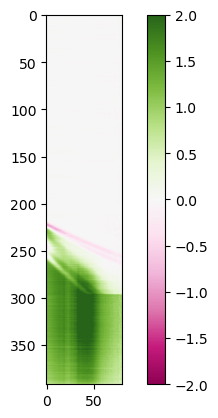

In [65]:
power_to_analyze = -2.0

times, ta_data = load_raw(power_to_analyze)

plt.figure()
plt.imshow(ta_data[:,:], vmin=-2, vmax=2, cmap='PiYG')
plt.colorbar()
plt.show()

[1.25909065e+00 4.04073310e+03 3.12609559e+01]


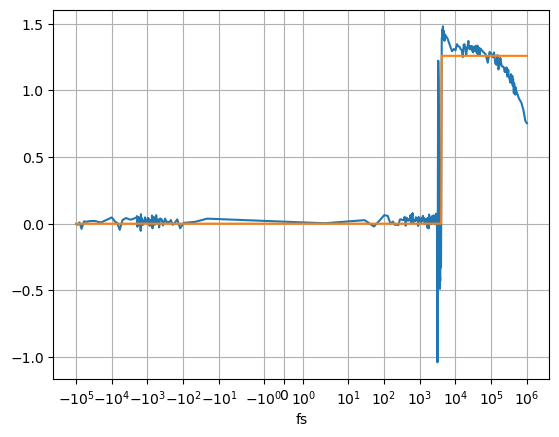

[1.33112515e+00 3.84124714e+03 4.73783143e+02]


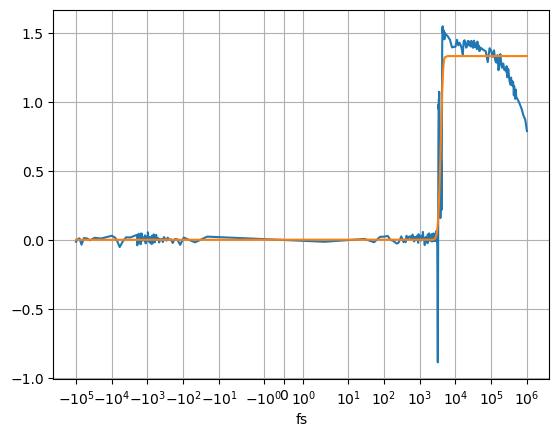

[1.43376625e+00 3.85960399e+03 4.18484944e+02]


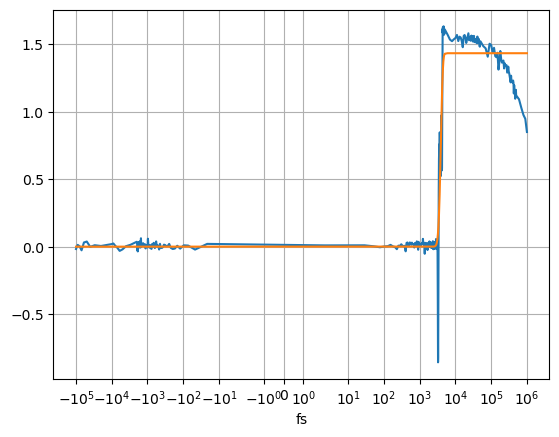

[1.49301515e+00 3.90627501e+03 3.71967337e+02]


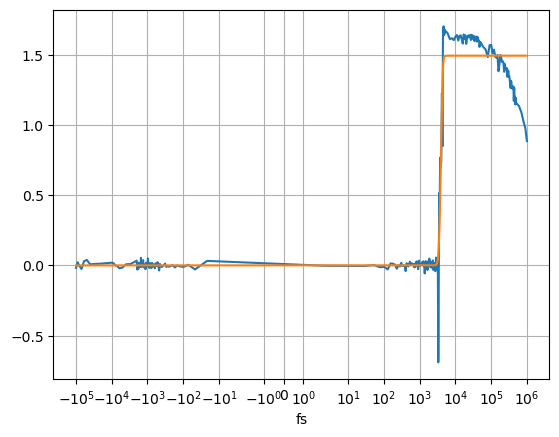

[1.46517269e+00 3.97401335e+03 3.24056804e+02]


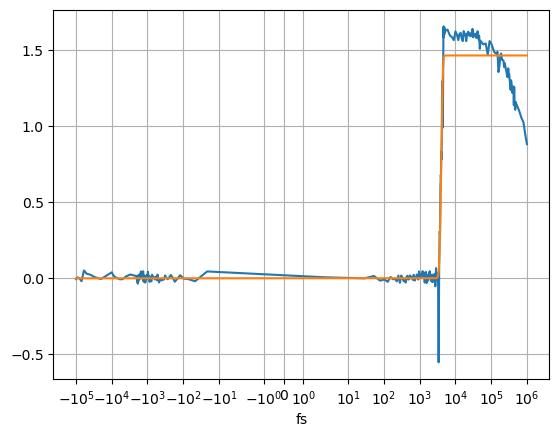

[1.49021765e+00 4.05499763e+03 2.93964784e+02]


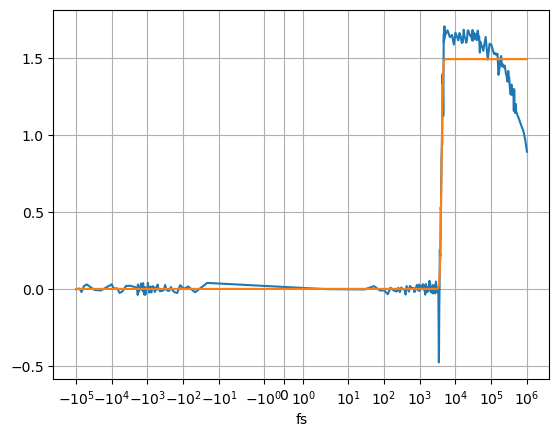

[1.64278487e+00 4.14927711e+03 2.80307329e+02]


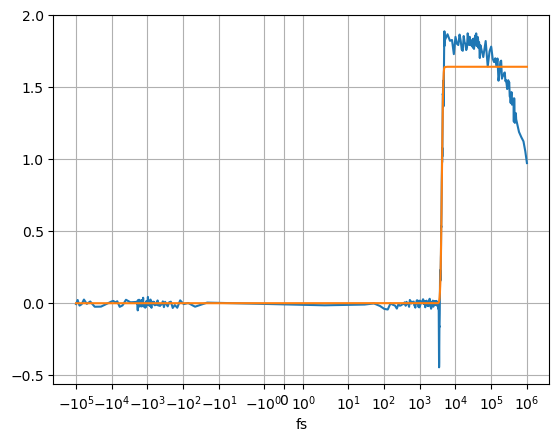

[1.86338682e+00 4.23747064e+03 2.61519975e+02]


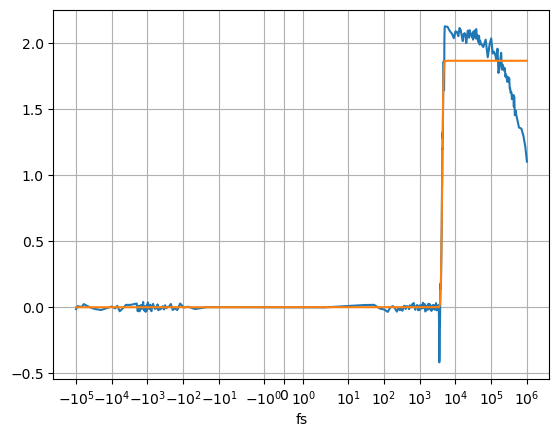

[1.90173887e+00 4.32287256e+03 2.56242955e+02]


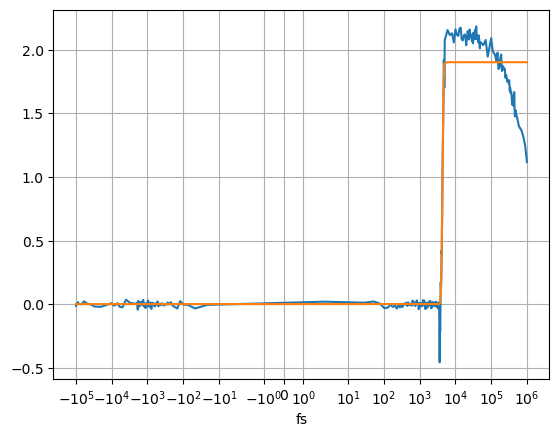

[1.89552593e+00 4.41932111e+03 2.64219354e+02]


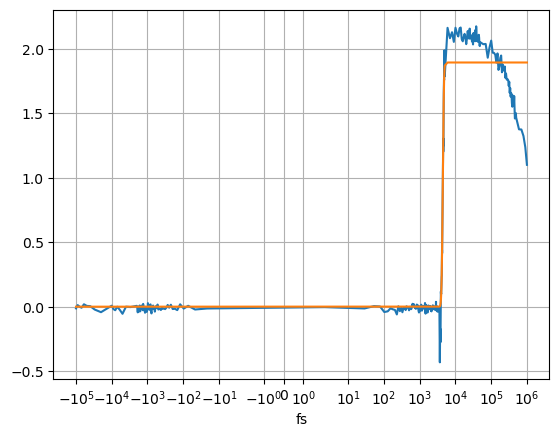

[1.73875714e+00 4.50590641e+03 2.78953881e+02]


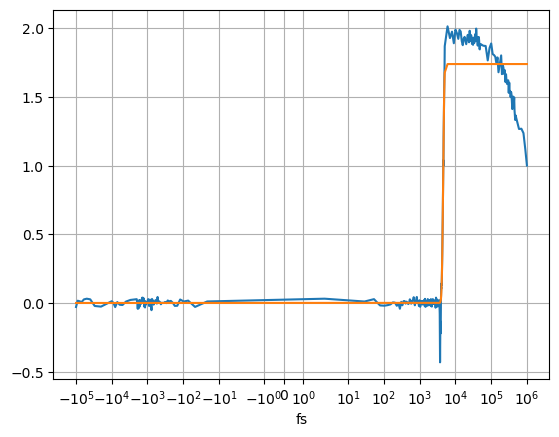

[1.42708631e+00 4.61654929e+03 2.81883915e+02]


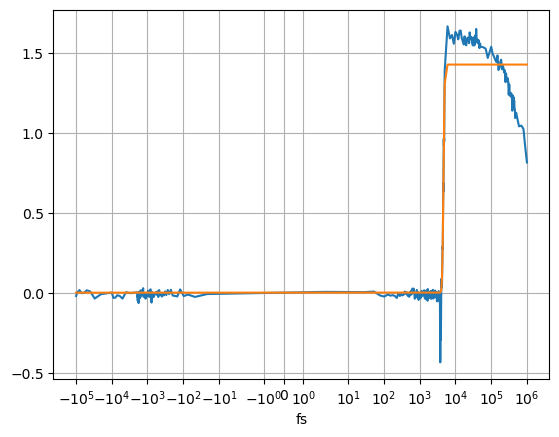

[1.18421983e+00 4.73780771e+03 2.84542773e+02]


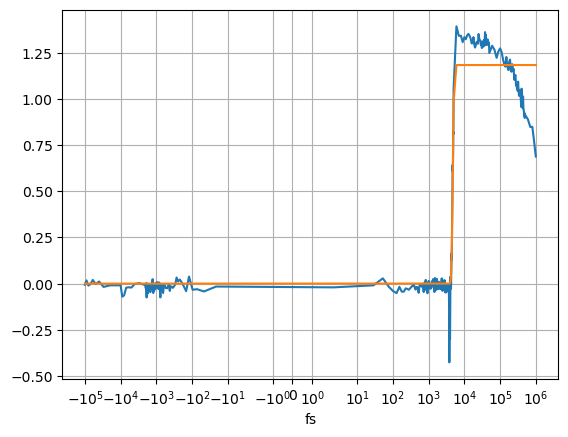

[1.08007007e+00 4.85177689e+03 2.99327031e+02]


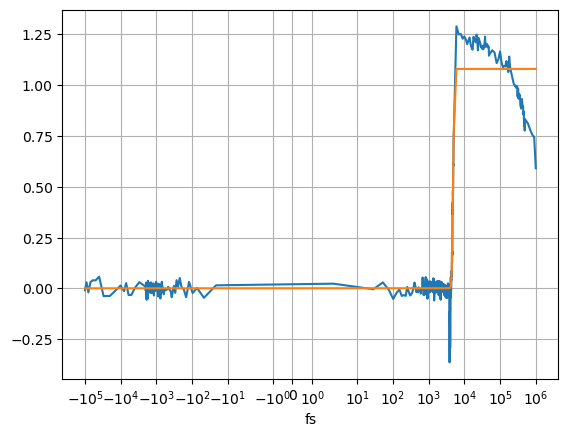

[9.74931313e-01 4.94348060e+03 3.35310979e+02]


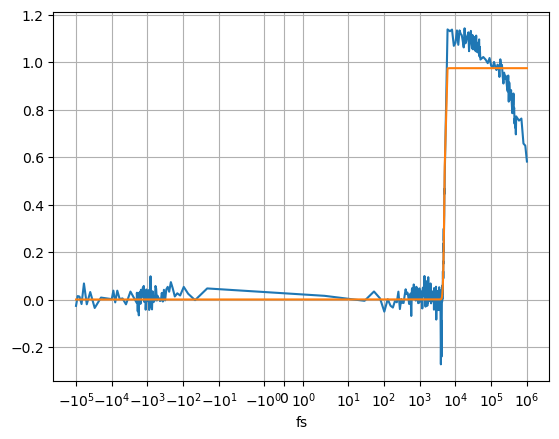

[9.00370430e-01 4.97826583e+03 3.56901868e+02]


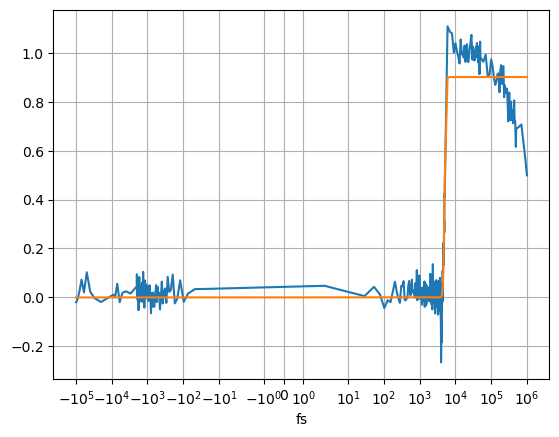

In [66]:
subset = np.s_[0::5]

t0s, poly_coefs = fit_t0_with_erf(times, wavelengths[subset], ta_data[:,subset], plot=True)

[-4.34211910e-03  1.14083294e+01 -7.90626380e+02]


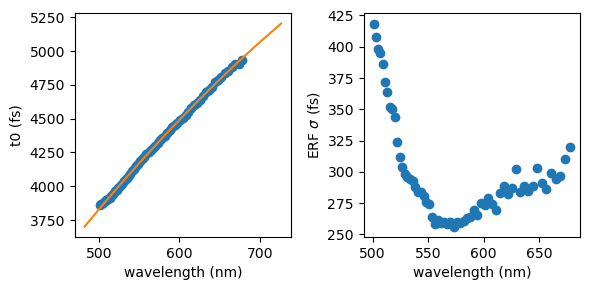

In [99]:
subset = np.s_[10:-10]
#subset = np.s_[:]

t0s, poly_coefs, sigmas = fit_t0_with_erf(times, wavelengths[subset], ta_data[:,subset], return_sigmas=True)

print(poly_coefs)

poly_f = np.poly1d(poly_coefs)

plt.figure(figsize=(6,3))

plt.subplot(121)
plt.plot(wavelengths[subset], t0s, 'o')
plt.plot(wavelengths, poly_f(wavelengths))
#plt.ylim([3e3, 5.5e3])

plt.xlabel('wavelength (nm)')
plt.ylabel('t0 (fs)')

plt.subplot(122)
plt.plot(wavelengths[subset], sigmas, 'o')
plt.xlabel('wavelength (nm)')
plt.ylabel('ERF $\sigma$ (fs)')

plt.tight_layout()
plt.show()

## interpolate to correct

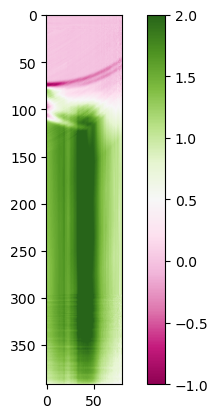

In [61]:
dechirped_data = dechirp(times, poly_f(wavelengths), ta_data)[:,:]

plt.figure()
plt.imshow(dechirped_data, vmin=-1, vmax=2, cmap='PiYG')
plt.colorbar()
plt.show()

In [109]:
# save for other analyses

filename = os.path.basename(raw_data[power_to_analyze])
time_wavelength_stack = np.hstack([times[:,None], dechirped_data])

np.savetxt(f'../mmCPD_TA_dec2021_data/mmCPD_TA_feb2022_data_dechirped/{filename}', time_wavelength_stack)

## and try SVD

[8.64821511e+01 1.22604465e+01 8.86267860e-01 1.77594820e-01
 6.24004582e-02]


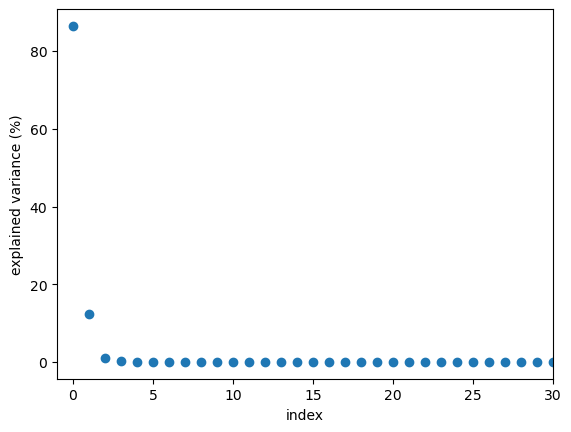

In [62]:
U, S, Vh = np.linalg.svd(dechirped_data - dechirped_data.mean(), full_matrices=True)
explained_variance = np.square(S) / np.sum(np.square(S)) * 100.0

print(explained_variance[:5])

plt.figure()
plt.plot(explained_variance, 'o')
plt.xlabel('index')
plt.ylabel('explained variance (%)')
plt.xlim([-1, 30])
plt.show()

## Compare +/- DNA at 2 mW

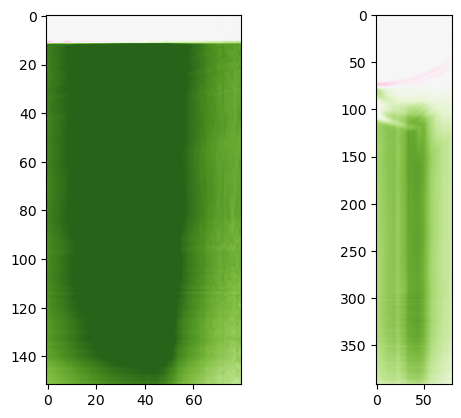

In [63]:
# times_wDNA, ta_data_wDNA   = load_raw(2.0)
# times_woDNA, ta_data_woDNA = load_raw(-2.0)

# dechirped_data_wDNA = dechirp(times_wDNA, poly_f(wavelengths), ta_data_wDNA)
# dechirped_data_woDNA = dechirp(times_woDNA, poly_f(wavelengths), ta_data_woDNA)

# plt.figure()
# plt.subplot(121)
# plt.imshow(dechirped_data_wDNA, vmin=-3, vmax=3, cmap='PiYG')
# plt.subplot(122)
# plt.imshow(dechirped_data_woDNA, vmin=-3, vmax=3, cmap='PiYG')
# plt.show()

In [84]:
component_signs = [1,-1,-1] # dictates the sign of each component & how many to plot
Nc = len(component_signs)

U, S, Vh = np.linalg.svd(dechirped_data[:,:], full_matrices=False)
print(f'S = {S[:4] / S.sum()}')

S = [0.82344115 0.04385515 0.01885027 0.0147828 ]


[]

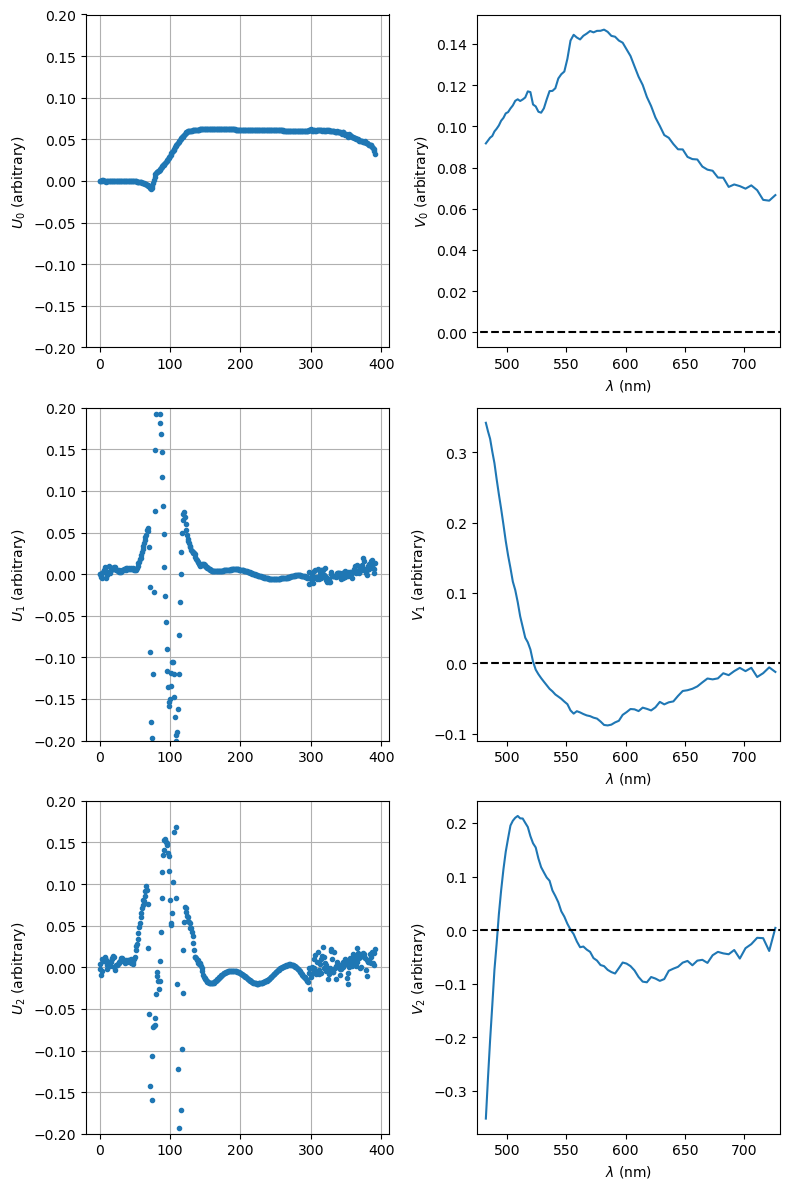

In [86]:

plt.figure(figsize=(8,4 * Nc))

for component in range(Nc):

    axL = plt.subplot(Nc,2,2*component+1)
    axR = plt.subplot(Nc,2,2*component+2)

    sign = component_signs[component]

    axL.plot(sign * U[:,component], '.')
    axR.plot(wavelengths, sign * Vh[component,:].T)

    axL.set_ylabel(f'$U_{component}$ (arbitrary)')
    axR.set_ylabel(f'$V_{component}$ (arbitrary)')

    axR.hlines([0], 450, 750, linestyles='--', color='k')

    axR.set_xlabel('$\lambda$ (nm)')
    axR.set_xlim([475, 730])
    axL.set_ylim([-0.2, 0.2])
    axL.grid()


plt.tight_layout()
plt.plot()

## details of single component

[6.80547937e-07 9.78757271e-01 8.14026274e+01 3.81125816e+02] [5.13887251e-08 5.99638921e-03 1.67210408e+01 2.33905439e+01]
raw data wo/DNA delta-T (ps): 250000.0


[]

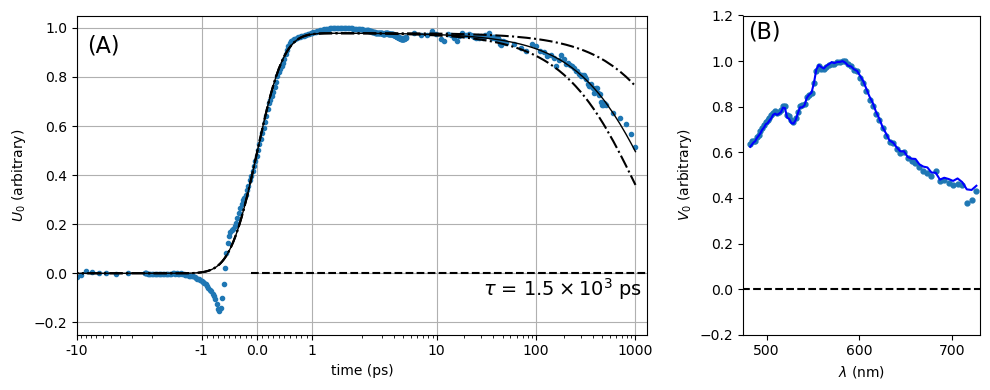

In [108]:
SELECTED_COMPONENT = 0
RAW_DATA_INDEX_TO_PLOT = 361

# -----

fig = plt.figure(figsize=(10,4), tight_layout=True)

gs = gridspec.GridSpec(1,3)
axL = fig.add_subplot(gs[:2])
axR = fig.add_subplot(gs[-1])

sign = component_signs[SELECTED_COMPONENT]

y = sign * U[:, SELECTED_COMPONENT]
y /= y.max()

# parameters: expt_decay_const, ERF_amplitude, ERF_t0, ERF_sigma
expntl = lambda t, lamb, erf_amp, erf_tzero, erf_sigma: np.exp(-lamb*t) * param_erf(t, erf_amp, erf_tzero, erf_sigma)

p0 = (1e-6, 1.0, 1e3, 1e2)
p_opt, p_cov = curve_fit(expntl,  times[:-1],  y[:-1],  p0=p0)
p_err = 3.0 * np.sqrt(np.diag(p_cov))
print(p_opt, p_err)

times_t0corrected_in_ps = (times - p_opt[2]) * 1e-3
axL.plot(times_t0corrected_in_ps, y, '.')
axL.plot(times_t0corrected_in_ps, expntl(times, *p_opt), color='k',lw=1)



axL.set_ylabel(f'$U_{SELECTED_COMPONENT}$ (arbitrary)')
axR.set_ylabel(f'$V_{SELECTED_COMPONENT}$ (arbitrary)')

axL.hlines([0], -1e-1, 1e4, linestyles='--', color='k')
axR.hlines([0], 450, 750, linestyles='--', color='k')


axL.text(2.9e1, -0.09, r'$\tau$ = $%s$ ps' % (latex_float(1e-3/p_opt[0])), fontdict={'size' : 14})
vh_wo_dna = normed_spectral_component

# "error" bounds
p_example = [1.0/1e6, p_opt[1], p_opt[2], p_opt[3]]
axL.plot(times_t0corrected_in_ps, expntl(times, *p_example), '-.', color='k')

p_example[0] = 1.0/4e6
axL.plot(times_t0corrected_in_ps, expntl(times, *p_example), '-.', color='k')

# plot spectral component from data
print('raw data wo/DNA delta-T (ps):', times[RAW_DATA_INDEX_TO_PLOT])
raw_spectrum_wo_dna = dechirped_data[RAW_DATA_INDEX_TO_PLOT] / dechirped_data[RAW_DATA_INDEX_TO_PLOT].max()
axR.plot(wavelengths, raw_spectrum_wo_dna, '.', color='#1f77b4', markersize=7)

vh = sign * Vh[SELECTED_COMPONENT,:].T
normed_spectral_component = vh / vh.max()
axR.plot(wavelengths, normed_spectral_component, color='blue')


axL.set_xlabel('time (ps)')
axR.set_xlabel('$\lambda$ (nm)')
axL.set_xscale('symlog')

axL.set_xlim([-1e1, 1.3e3])
axR.set_xlim([475, 730])

xticks = [-10, -1, 0.0, 1, 10, 100, 1000]
axL.set_xticks(xticks)
axL.set_xticklabels(xticks)

minor_ticks = [
    np.linspace(-10, -1, 11),
    np.linspace(-1, 1, 21),
    np.linspace(1, 10, 11),
    np.linspace(10, 100, 11),
    np.linspace(100, 1000, 11),
]
axL.set_xticks(np.concatenate(minor_ticks), minor=True)

axL.set_ylim([-0.25, 1.05])
axR.set_ylim([-0.2, 1.2])

axL.text(-8, .9, '(A)', fontsize=16)
axR.text(480, 1.1, '(B)', fontsize=16)

plt.tight_layout()
axL.grid()
plt.savefig('observed_time_dynamics.pdf')
plt.plot()

### No SVD

[]

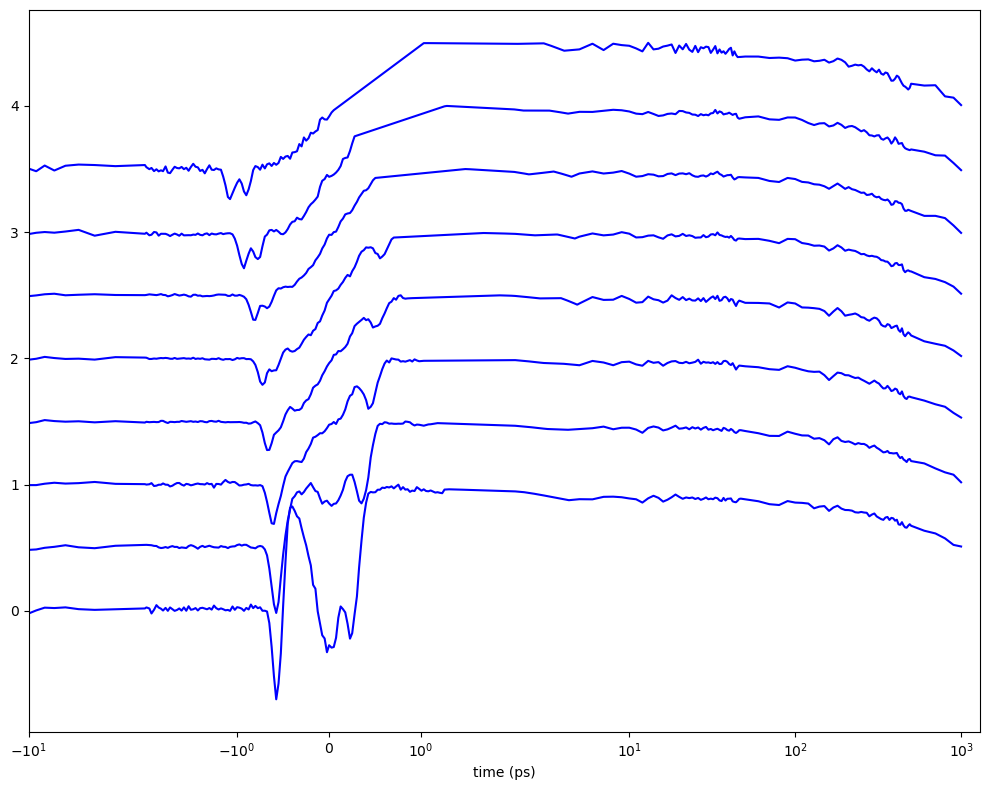

In [80]:

fig = plt.figure(figsize=(10,8), tight_layout=True)

axL = plt.subplot(111)

for si in range(8):
    dA = dechirped_data[:,si*10]
    axL.plot((times) * 1e-3, dA / dA.max() + 0.5 * si, color="blue")

axL.set_xlabel('time (ps)')
axR.set_xlabel('$\lambda$ (nm)')
axL.set_xscale('symlog')

axL.set_xlim([-1e1, 1.3e3])
axR.set_xlim([475, 730])

plt.tight_layout()
plt.plot()